In [1]:
# Import Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as st
from config import gkey
import gmaps
import requests
import time

In [2]:
# Load the Size History by County csv to a DataFrame
size_history_data_path = "../cleaned_data/Electric_Vehicle_Population_Size_History_By_County_Cleaned.csv"
size_history_full_data = pd.read_csv(size_history_data_path)

In [3]:
size_history_full_data.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,January 31 2017,Juneau,AK,Passenger,0,1,1,49,50,2.00
1,January 31 2017,Dale,AL,Passenger,0,1,1,71,72,1.39
2,January 31 2017,Russell,AL,Passenger,1,0,1,53,54,1.85
3,January 31 2017,Maricopa,AZ,Passenger,2,0,2,1774,1776,0.11
4,January 31 2017,Pima,AZ,Passenger,0,1,1,439,440,0.23


In [4]:
# Refine to most recent date in history (October 31 2021)
size_history_data = size_history_full_data.loc[size_history_full_data["Date"]=="October 31 2021"]
size_history_data

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
11420,October 31 2021,Fairbanks North Star,AK,Passenger,0,1,1,62,63,1.59
11421,October 31 2021,Montgomery,AL,Passenger,0,1,1,30,31,3.23
11422,October 31 2021,Maricopa,AZ,Passenger,1,0,1,597,598,0.17
11423,October 31 2021,Alameda,CA,Passenger,1,0,1,157,158,0.63
11424,October 31 2021,Fresno,CA,Passenger,1,0,1,128,129,0.78
...,...,...,...,...,...,...,...,...,...,...
11609,October 31 2021,Whitman,WA,Passenger,69,57,126,21414,21540,0.58
11610,October 31 2021,Whitman,WA,Truck,2,0,2,8338,8340,0.02
11611,October 31 2021,Yakima,WA,Passenger,282,166,448,163726,164174,0.27
11612,October 31 2021,Yakima,WA,Truck,5,0,5,59634,59639,0.01


# States with most EVs

In [5]:
# Group dataframe into States, then summarise columns of interest
state_data_EV_count = size_history_data.groupby("State")["Electric Vehicle (EV) Total"].sum()
state_data_total_count = size_history_data.groupby("State")["Total Vehicles"].sum()
state_data_percent = (state_data_EV_count / state_data_total_count)*100
state_data_percent = state_data_percent.map("{:.2f}".format)

# Assemble columns into dataframe
state_data = pd.DataFrame(
    {"Total Electric Vehicle (EV)": state_data_EV_count,
     "Total Vehicles": state_data_total_count,
     "Percent Electric Vehicles": state_data_percent
    }
)

# Sort data by descending order
state_data_sorted_percent = state_data.sort_values("Percent Electric Vehicles", ascending=False)
state_data_sorted_count = state_data.sort_values("Total Electric Vehicle (EV)", ascending=False)

# Display data
state_data_sorted_count

,Total Electric Vehicle (EV),Total Vehicles,Percent Electric Vehicles
State,,,
WA,82851,6099984,1.36
CA,47,5012,0.94
VA,33,2270,1.45
MD,25,894,2.80
TX,15,1304,1.15
NC,8,722,1.11
OR,8,465,1.72
GA,7,491,1.43
FL,6,486,1.23


We originally intended to use this dataset to find the population of electric vehicles across all US states. Analysis of the data in the above table and heatmap showed that despite this dataset including data for various US states, there was far more data available for Washington and its counties than data available for the other states and counties. For example, the data summarised that Wisconsin only has a total of 4 electrical and non-electrical vehicles, which is highly inaccurate. Because of this, we concluded that the dataframe does not include all vehicle data for other states as expected, and thus we decided to reduce the data to only include Washington data, in order to prevent incorrect insights from other state data in our analysis.

In [6]:
# Use loc function to create dataframe for only Washington data
size_history_data_reduced = size_history_data.loc[size_history_data["State"]=="WA"]

# Counties with highest number and highest percentage of EVs

In [7]:
# Copy and group dataframe into Counties, then summarise columns of interest
county_data_EV_count = size_history_data_reduced.groupby("County")["Electric Vehicle (EV) Total"].sum()
county_data_total_count = size_history_data_reduced.groupby("County")["Total Vehicles"].sum()
county_data_percent = (county_data_EV_count / county_data_total_count)*100
county_data_percent = county_data_percent.map("{:.2f}".format)

# Assemble columns into dataframe
county_data = pd.DataFrame(
    {"Total Electric Vehicle (EV)": county_data_EV_count,
     "Total Vehicles": county_data_total_count,
     "Percent Electric Vehicles": county_data_percent
    }
)

# Sort data by descending order
county_data_sorted_percent = county_data.sort_values("Percent Electric Vehicles", ascending=False)
county_data_sorted_count = county_data.sort_values("Total Electric Vehicle (EV)", ascending=False)

# Display data
county_data_sorted_count

,Total Electric Vehicle (EV),Total Vehicles,Percent Electric Vehicles
County,,,
King,43352,1560184,2.78
Snohomish,8933,657596,1.36
Pierce,6307,693060,0.91
Clark,4814,399337,1.21
Kitsap,3005,233287,1.29
Thurston,2808,249944,1.12
Whatcom,2275,191178,1.19
Spokane,2016,420651,0.48
Island,1029,84245,1.22


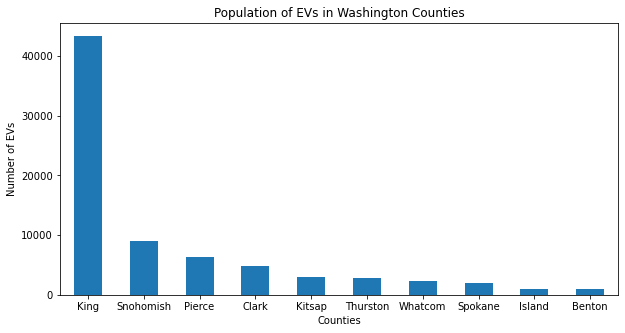

In [8]:
# Plot bar graph to show the top 10 counties of Washington with the highest population of EVs
plt.figure(figsize=(10,5))
county_data_sorted_count["Total Electric Vehicle (EV)"].head(10).plot.bar(rot=0)
plt.title("Population of EVs in Washington Counties")
plt.xlabel("Counties")
plt.ylabel("Number of EVs")
plt.savefig("../figures/EVPopulationWashingtonCounties.png")
plt.show()

In [9]:
# Create heatmap outlining population of EVs in each Washington county
# Read in the csvs containing county centroid coordinates
county_centroids = pd.read_csv("../cleaned_data/WA_County_Locations.csv")

# Merge the datasets using the county columns
county_data_merged = pd.merge(county_data, county_centroids, on="County")
county_data_merged

,County,Total Electric Vehicle (EV),Total Vehicles,Percent Electric Vehicles,Latitude,Longitude
0,Adams,31,17785,0.17,46.990000,-118.560000
1,Asotin,40,19022,0.21,46.180000,-117.190000
2,Benton,1028,175996,0.58,46.250000,-119.500000
3,Chelan,497,75994,0.65,47.880000,-120.640000
4,Clallam,604,71621,0.84,48.112500,-123.440833
5,Clark,4814,399337,1.21,45.770000,-122.480000
6,Columbia,10,3894,0.26,46.300000,-117.920000
7,Cowlitz,438,98674,0.44,46.190000,-122.680000
8,Douglas,159,40140,0.40,47.740000,-119.690000
9,Ferry,14,7807,0.18,48.470000,-118.510000


In [10]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

# Store variables
locations = county_data_merged[["Latitude", "Longitude"]].astype(float)
county_EV_population = county_data_merged["Total Electric Vehicle (EV)"].astype(float)

# Create a heatmap layer
fig = gmaps.figure()
heat_layer = gmaps.heatmap_layer(locations, weights=county_EV_population, 
                                 dissipating=False, max_intensity=20000,
                                 point_radius = 1)
fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

### **Findings**

As of October 31 2021, Washington had 82851 total electric vehicles, making up 1.36 percent of their total vehicles. San Juan has the highest percentage of electric vehicles out of total vehicles with 2.96% (600 electric vehicles out of 20267 total vehicles). King, Washington has the highest count of electric vehicles with 43352 vehicles, making up 2.78 percent of their total vehicles.

# Highest population in the US: battery EVs or plug-in EVs?

In [11]:
# Get totals of BEVs and PHEVs
total_BEVs = size_history_data_reduced["Battery Electric Vehicles (BEVs)"].sum()
total_PHEVs = size_history_data_reduced["Plug-In Hybrid Electric Vehicles (PHEVs)"].sum()

print(f"There are {total_BEVs} total Battery Electric Vehicles and {total_PHEVs} total Plug-In Hybrid Electric Vehicles in Washington.")

There are 61212 total Battery Electric Vehicles and 21639 total Plug-In Hybrid Electric Vehicles in Washington.


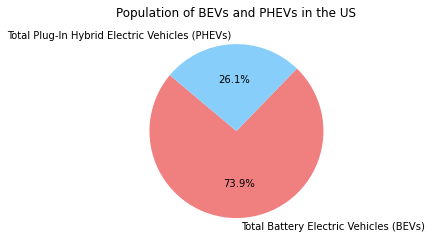

In [12]:
# Plot a pie graph with totals of BEVs and PHEVs
plt.pie([total_BEVs,total_PHEVs], labels=["Total Battery Electric Vehicles (BEVs)","Total Plug-In Hybrid Electric Vehicles (PHEVs)"], colors=["lightcoral", "lightskyblue"],
        autopct="%1.1f%%", startangle=140)
plt.title("Population of BEVs and PHEVs in the US")
plt.savefig("../figures/PopulationBEVsandPHEVs.png")
plt.show()

### **Findings**

As of October 31 2021, there were 61335 total Battery Electric Vehicles and 21719 total Plug-In Hybrid Electric Vehicles in Washington. This shows that Battery Electric Vehicles are more popular than Plug-In Hybrid Electric Vehicles. This is likely because Tesla was found to be the most popular electric vehicle brand in Washington, and all but one of Tesla’s vehicle models are battery electric vehicles. Additionally, electric vehicle customers may want to use more environmentally-friendly fuel sources, and thus may avoid vehicles that use gasoline including hybrid vehicles.

# **Adoption of Electric Vehicles over Time**

In [19]:
# Change date format
size_history_full_data["Date (formatted)"] = pd.to_datetime(size_history_full_data["Date"],format="%B %d %Y")

# Use loc function to create dataframe for only Washington data
size_history_full_data_reduced = size_history_full_data.loc[size_history_full_data["State"]=="WA"]

# Group data by date, then summarise columns of interest
date_data_EV_count = size_history_full_data_reduced.groupby("Date (formatted)")["Electric Vehicle (EV) Total"].sum()
date_data_total_count = size_history_full_data_reduced.groupby("Date (formatted)")["Total Vehicles"].sum()
date_data_percent = (date_data_EV_count / date_data_total_count)*100
date_data_percent = date_data_percent.map("{:.2f}".format)

# Assemble columns into dataframe
date_data = pd.DataFrame(
    {"Total Electric Vehicle (EV)": date_data_EV_count,
     "Total Vehicles": date_data_total_count,
     "Percent Electric Vehicles": date_data_percent
    }
)

# Display data
date_data

,Total Electric Vehicle (EV),Total Vehicles,Percent Electric Vehicles
Date (formatted),,,
2017-01-31,22576,6025001,0.37
2017-02-28,23313,6028035,0.39
2017-03-31,24029,6040327,0.40
2017-04-30,24842,6046301,0.41
2017-05-31,25563,6057025,0.42
2017-06-30,26332,6068820,0.43
2017-07-31,27032,6074850,0.44
2017-08-31,27690,6087018,0.45
2017-09-30,28413,6098212,0.47


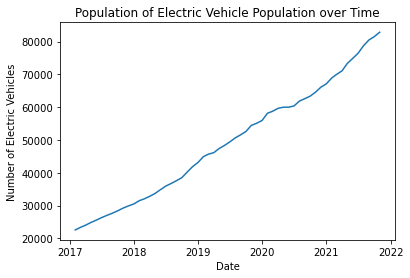

In [20]:
# Plot line graph of electric vehicle population over time
size_history_dates = date_data.index
size_history_EV_population = date_data["Total Electric Vehicle (EV)"]
size_history_total_population = date_data["Total Vehicles"]
size_history_EV_percent = date_data["Percent Electric Vehicles"]

plt.plot(size_history_dates,size_history_EV_population,label = "Total Electric Vehicle (EV)")
plt.title("Population of Electric Vehicle Population over Time")
plt.xlabel('Date')
plt.ylabel('Number of Electric Vehicles')
plt.savefig("../figures/PopulationEVs.png")
plt.show()

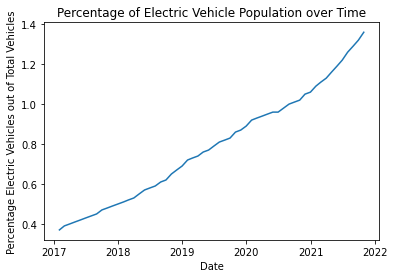

In [21]:
# Plot line graph of electric vehicle percent of total vehicles over time
size_history_EV_percent_int = pd.to_numeric(size_history_EV_percent, downcast='integer')
plt.plot(size_history_dates,size_history_EV_percent_int)
plt.title("Percentage of Electric Vehicle Population over Time")
plt.xlabel('Date')
plt.ylabel('Percentage Electric Vehicles out of Total Vehicles')
plt.savefig("../figures/PercentageEVs.png")
plt.show()

In [22]:
# Convert dates to integers to perform linear regression
date_data.index = date_data.index.map(dt.date.toordinal)
size_history_dates = date_data.index

In [23]:
# Calculate the correlation coefficient and linear regression model for EV population and total vehicle population
(slope1, intercept1, rvalue1, pvalue1, stderr1) = st.linregress(size_history_dates,size_history_EV_population)
(slope2, intercept2, rvalue2, pvalue2, stderr2) = st.linregress(size_history_dates,size_history_total_population)
line_eq1 = "y = " + str(round(slope1,2)) + "x + " + str(round(intercept1,2))
line_eq2 = "y = " + str(round(slope2,2)) + "x + " + str(round(intercept2,2))

print(f"Calculated trendline for EV population is {line_eq1}.")
print(f"Calculated trendline for total vehicle population is {line_eq2}.")

projected_date = dt.date(2025, 1, 31)
projected_date_ordinal = projected_date.toordinal()
projected_EV_population = round(((34.28*projected_date_ordinal) - 25219008.22), 0)
projected_total_vehicle_population = round(((139.22*projected_date_ordinal) - 96400635.31), 0)
projected_EV_percent = round(((projected_EV_population / projected_total_vehicle_population)*100), 2)

print(f"For January 31 2025, we may project that the electric vehicle population is {projected_EV_population}, and the total vehicle population is {projected_total_vehicle_population}, resulting in the percentage of electric vehicles being {projected_EV_percent}%.")

Calculated trendline for EV population is y = 34.22x + -25179011.8.
Calculated trendline for total vehicle population is y = 144.38x + -100225304.55.
For January 31 2025, we may project that the electric vehicle population is 123579.0, and the total vehicle population is 6522205.0, resulting in the percentage of electric vehicles being 1.89%.


### Findings

From the table and the line plot above, we can see that the population and percentage of electric vehicles has consistently increased over time between January 31 2017 and October 31 2021. This data can be used to estimate that by January 31 2025, the population of electric vehicles in Washington may increase to 123,579, which may be 1.89% of a potential 6,522,205 vehicles in Washington at that time.